In [1]:
import numpy as np
import pandas as pd
import nbimporter
import matplotlib.pyplot as plt

from s10_home_electric_appliance_refrigerator_2 import calc_E_elc as get_e_elec_refrigerator

Importing Jupyter notebook from s10_home_electric_appliance_refrigerator_2.ipynb


# 家電

## 定義

省エネ基準の解説書では以下のように定義されている。

>一般消費者の生活の用に供され、電気を機能上重要な作動のために使用する機械器具及びこれらの電源として使用される電池類で、商用交流電源を使用するもののほか、電池を使用するものを含む。ただし、住宅設備としてあらかじめ工事により住宅に設置されることを目的として設計、製造されたものは除く。

https://www.kenken.go.jp/becc/documents/house/1_181016_v06_PVer0205.pdf

p.1-7　2.55節

つまり、工事の発生しない「電気機械器具」および「電池」を対象とする？

## 年間消費電力量の計算

### 家電群の年間消費電力量

ここでは、住宅に持ち込まれた評価対象となる全ての家電を家電群と呼称する。  
家電群の年間消費電力量$E_{elc,HEAs,y}$ [Wh/year] は、住宅に持ち込まれた$i$個の家電の年間消費電力$E_{elc,HEA,i,y}$ [Wh/year]の積算値である。

$$
E_{elc,HEAs,y} = \sum E_{elc,HEA,i,y}
$$

In [2]:
def get_E_elc_HEAs(E_elc_HEAs):
    return np.sum(E_elc_HEAs)

### 家電毎の年間消費電力

家電$i$の年間消費電力量$E_{elc,HEAs,i,y}$は、計算ステップ$step$時の家電$i$の消費電力量$E_{elc,HEA,i,step}$ [Wh] の積算値である。  
家電の立ち上がりや経過による変動に対応するため、計算ステップの総和は通年とするがその間隔は家電毎に任意とする。  
他の住宅設備との電力収支を見る場合には、計算ステップ間隔は揃えた方が望ましい。  

$$
E_{elc,HEA,i,y} = \frac{1}{\eta_{batt-chrg,HEA,i} \times \eta_{batt-dischrg,HEA,i}} \times \sum \frac{t_{sec,step} \times P_{elc,HEA,i,step}}{3600}　 
$$

$\eta_{batt-chrg,HEA,i}$ :家電$i$に内蔵された充電池(<u>batt</u>ery)の充電(<u>ch</u>a<u>rg</u>e)効率（充電池を内蔵しない場合は1とする） [-]  
$\eta_{batt-dischrg,HEA,i}$ :家電$i$に内蔵された充電池の放電(<u>disch</u>a<u>rg</u>e)効率（充電池を内蔵しない場合は1とする） [-]  
$t_{sec,step}$ :家電$i$の計算ステップ$step$の秒数 [s]  
$P_{elc,HEA,i,step}$ :家電$i$の計算ステップ$step$時の消費電力(<u>el</u>e<u>c</u>tric <u>P</u>ower) [W]  


計算ステップ$step$時の家電$i$の消費電力$P_{elc,HEA,i,step}$ は、在室者や生活スケジュールから設定される家電の稼働状態のスケジュールと家電毎の各稼働状態の消費電力から求まる。

In [3]:
def get_E_elc_HEA(eta_batt_chrg, eta_batt_dischrg, t_sec_steps, P_elc_HEA_steps):
    E_elc_HEA = 1 / (eta_batt_chrg * eta_batt_dischrg) * np.sum(t_sec_steps * P_elc_HEA_steps)
    return E_elc_HEA

### 家電iの稼働状態スケジュールの書式と作成する計算パラメーター用辞書データ

在室者や生活スケジュールから設定される家電の稼働スケジュールは、以下の書式とする。  
これは、スケジュールプログラムで作成するため、家電とは独立している。


|計算ステップ(step)  |0  |1  |…　|n  |  
|:-----------:| :-:| :-:| :-:| :-:|  
|稼働開始時間(t_step_strt) | 1/1 0:00 | 1/1 0:15 | … | 12/31 23:45 | 
|稼働状態(Stat_num) | 3 | 1 | … | 2 |   

上記の書式から以下の辞書を作成する
* (key)計算ステップ番号
* 稼働開始時間
* 稼働状態値
* 継続秒数

In [4]:
stp = np.array([0,1,2])
tm = np.array(['2001-01-01T00:00:00', '2001-01-01T00:15:00', '2001-12-31T23:45:00'], dtype='datetime64')
stat = np.array([3,1,2])
sec = np.array([(np.datetime64(tm[1]) - np.datetime64(tm[0])).item().total_seconds(), \
                (np.datetime64(tm[2]) - np.datetime64(tm[1])).item().total_seconds(), \
                (np.datetime64('2002-01-01T00:00:00') - np.datetime64(tm[2])).item().total_seconds()])
schedule_of_HEA = dict(zip(stp, zip(tm, stat, sec)))

print(schedule_of_HEA)

{0: (numpy.datetime64('2001-01-01T00:00:00'), 3, 900.0), 1: (numpy.datetime64('2001-01-01T00:15:00'), 1, 31534200.0), 2: (numpy.datetime64('2001-12-31T23:45:00'), 2, 900.0)}


### 家電iに必要な関数

家電$i$に必要な関数は、スケジュールから渡される稼働状態値の消費電力を返す。  
これは各家電毎に定義する。  

例えば、  
ドライヤーは時刻変動による消費電力の変化が無いため、計算ステップ時の稼働状態（ON/OFF）のみを引数として消費電力を返すことが出来る。  


一方で  
冷蔵庫など周囲空気の影響を受ける場合は「時刻」「気象条件」などの複数の引数が必要になってしまう。  

このような場合は、辞書データを増やすのではなく
家電関数を呼び出した際に、家電側の初期化関数で「気象条件など」読み込みを行う形にしたい。  

ただし、  
気象データ等のデータベースは初回のみ読み込みをしたい。さらに、家電の計算を終了する際に破棄するコードが余分に必要になる。  



$$
P_{elc,HEA,i,step} =
\begin{cases}
P_{elc,state,0} & 稼働状態1\\
P_{elc,state,1} & 稼働状態2\\
… & …\\
P_{elc,state,n} & 稼働状態n\\
\end{cases}
$$

$P_{elc,state,n}$ :稼働状態$n$の消費電力 [W] 


| 稼働条件 | 消費電力 | 説明 |   
|:-------:|:-------:|:----:|    
|0        |0        |停止 |  
|1        |3      |休止 |
|2        |20      |待機 |
|3        |100      |低負荷時 |
|…        |…      |… |
|n        |300      |高負荷時 |


In [5]:
def get_E_elc_HEA_sample_steps(dictionary_of_HEA_schedule):
    
    key_list = dictionary_of_HEA_schedule.keys()
    t_sec_steps = np.zeros(len(key_list))
    P_elc_HEA_steps = np.zeros(len(key_list))
    
    for i in range(len(key_list)):
        t_sec_steps[i] = dictionary_of_HEA_schedule[i][2]
        if dictionary_of_HEA_schedule[i][1] == 0:
            P_elc_HEA_steps[i] = 0 
        elif dictionary_of_HEA_schedule[i][1] == 1:
            P_elc_HEA_steps[i] = 3
        elif dictionary_of_HEA_schedule[i][1] == 2:
            P_elc_HEA_steps[i] = 20 
        elif dictionary_of_HEA_schedule[i][1] == 3:
            P_elc_HEA_steps[i] = 100 
        else:
            raise ValueError(item)
    
    return t_sec_steps, P_elc_HEA_steps

In [6]:
get_E_elc_HEA_sample_steps(schedule_of_HEA)

(array([9.00000e+02, 3.15342e+07, 9.00000e+02]), array([100.,   3.,  20.]))

## サンプル計算

### 計算条件

- 家電1：
    - 内蔵充電池：なし
    - スケジュールは　sch1　
    - 稼働状態は　get_E_elc_HEA_sample_steps　
- 家電2：
    - 内蔵充電池：あり（充電効率　0.95、放電効率 0.96）
    - スケジュールは　sch2　
    - 稼働状態は　get_E_elc_HEA_sample_steps

In [7]:
#最終的にはスケジュールプログラムからsh1を直接読み込む
stp1 = np.array([0,1,2])
tm1 = np.array(['2001-01-01T00:00:00', '2001-01-01T00:30:00', '2001-12-29T23:45:00'], dtype='datetime64')
stat1 = np.array([3,1,2])
sec1 = np.array([(np.datetime64(tm1[1]) - np.datetime64(tm1[0])).item().total_seconds(), \
                (np.datetime64(tm1[2]) - np.datetime64(tm1[1])).item().total_seconds(), \
                (np.datetime64('2002-01-01T00:00:00') - np.datetime64(tm1[2])).item().total_seconds()])
sch1 = dict(zip(stp1, zip(tm1, stat1, sec1)))

In [8]:
#最終的にはスケジュールプログラムからsh2を直接読み込む
stp2 = np.array([0,1,2])
tm2 = np.array(['2001-01-01T00:00:00', '2001-01-01T00:15:00', '2001-12-31T05:45:00'], dtype='datetime64')
stat2 = np.array([3,1,2])
sec2 = np.array([(np.datetime64(tm2[1]) - np.datetime64(tm2[0])).item().total_seconds(), \
                (np.datetime64(tm2[2]) - np.datetime64(tm2[1])).item().total_seconds(), \
                (np.datetime64('2002-01-01T00:00:00') - np.datetime64(tm2[2])).item().total_seconds()])
sch2 = dict(zip(stp2, zip(tm2, stat2, sec2)))

In [9]:
def sample_calc():
    a1, b1 =get_E_elc_HEA_sample_steps(sch1)
    a2, b2 =get_E_elc_HEA_sample_steps(sch2)
    
    d = np.array([get_E_elc_HEA(1, 1, a1, b1), get_E_elc_HEA(0.95, 0.96, a2, b2)])
    return get_E_elc_HEAs(d)

In [10]:
sample_calc()

202792736.84210527

# 家電を上からたたくサンプル（三浦作成）

## 外気温度の読み込み

本来であれば家電の章とは別のところで行うべきであるが、とりあえずここで実施する。

In [11]:
def import_theta_ex_d() -> np.ndarray:
    """
    日平均外気温度を外部CSVファイルからND配列に読み込む
    Returns:
        theta_ext_d : 日平均外気温度[365], ℃ 
    """
    
    df = pd.read_csv('external_air_temperature_sample.csv', encoding='SHIFT_JIS')
    ds = df['日平均外気温度[℃]']
    theta_ext_d = ds.values
    return theta_ext_d

In [12]:
theta_ex_d = import_theta_ex_d()
theta_ex_d

array([-13. , -11.8,  -7.8,  -9.1, -10.4, -10.4, -14.6,  -5.9,  -9.9,
        -8.4, -10.1, -11.7,  -5.3, -10.1, -12.2, -13. ,  -5.7,  -0.5,
        -6. , -12. ,  -9.8,  -6. ,  -7.8, -11.5, -13.7, -10. ,  -5.8,
        -5.4,  -9. , -11.6, -13.1, -13.8, -15. , -14.2, -10.8, -10.3,
       -11.8,  -7.3,  -5.2,  -6.8,  -3.8,  -5.1,  -6.1, -11.2, -12.2,
       -11.6, -11.2,  -9.2, -13.5, -15.1, -15.2, -12.1,  -9.3,  -5.3,
         1.1,   0.4,  -1.8,  -4.2,  -6.6,  -9.1,  -7.9,  -4.5,  -9.2,
       -10.4,  -5.9,  -7.9,  -8.4,  -8.8,  -4.9,   0.9,   1.8,  -1.6,
        -2.6,  -3.2,  -3.6,  -1. ,  -0.1,   0.9,  -0.5,  -2.5,  -2.4,
         0.2,  -1.2,  -1.6,  -1.7,  -0.6,   0.6,  -0.6,  -1.6,  -2.1,
         0.2,   3. ,   3.1,   3.5,   3. ,   0.6,  -1.4,  -0.2,   2.4,
         5.1,   6.8,   9.1,  10.2,   9. ,   1.7,   2. ,   8. ,  12. ,
        10.6,   7.6,   0.5,   2.9,   2.8,   0.8,   3.9,   6.9,   8.2,
        14.2,  18.5,   9.6,   6.5,   8.4,   6.6,   5.4,   3.9,   6.3,
         8.2,   7.1,

## 冷蔵庫周囲温度の計算

これが本当に冷蔵庫の周囲温度なのであれば冷蔵庫モジュールに記述すべきである。しかし、建研で実施した実測結果からの近似式であることを考えると、どうやら居室の温度にほぼ等しいと考えられる。そうであれば、冷蔵庫周囲温度ではなく、居室の温度を使用しても差し支えないであろう。仮に冷蔵庫周囲温度だとしても、その説明変数はQ値等ではなく、居室の温度や離隔距離などを説明変数とすべき。ここでは、とりあえず、居室の温度ととらえ、冷蔵庫の上のモジュールで叩くことにする。

$$
\theta_{ amb, est, d } =
\begin{cases}
(0.0480 \times Q + 0.3666) \times \theta_{ ext, d } + (-1.2435 \times Q + 18.82) & (居室間歇暖房時) \\
(0.0604 \times Q + 0.3668) \times \theta_{ ext, d } + (-1.6265 \times Q + 19.99) & (全館連続暖房時) \\
\end{cases}
$$

$\theta_{amb,est,d}$ :日付$d$の冷蔵庫周辺空気の推定温度, ℃    
$\theta_{ext,d}$ :日付$d$の日平均外気温度, ℃    
$Q$ :住宅の熱損失係数, W/m<sup>2</sup> K    

In [13]:
def get_theta_amb_est_d(theta_ext_d: np.ndarray, Q: float, central_heating_exists: bool) -> np.ndarray:
    """
    冷蔵庫周辺空気の推定空気温度を取得する
    Args:
        theata_ext_d :日別の平均外気温度[365], ℃ 
        Q: 住宅の熱損失係数 W/m2K 
        central_heating_exists : 住宅の暖房方式（True:全館連続暖房, False:居室間歇暖房）
    Returns:
        日別の冷蔵庫周辺空気の推定温度[365], ℃
    """
    
    if central_heating_exists: # 全館連続暖房
        return (0.0604 * Q + 0.3668) * theta_ext_d + (-1.6265 * Q + 19.99)
    else: # 居室間歇暖房
        return (0.0480 * Q + 0.3666) * theta_ext_d + (-1.2435 * Q + 18.82)

In [14]:
get_theta_amb_est_d(theta_ex_d, 2.7, True)

array([ 8.71001 ,  9.345866, 11.465386, 10.776542, 10.087698, 10.087698,
        7.862202, 12.472158, 10.352638, 11.147458, 10.246662,  9.398854,
       12.790086, 10.246662,  9.133914,  8.71001 , 12.578134, 15.33351 ,
       12.41917 ,  9.23989 , 10.405626, 12.41917 , 11.465386,  9.50483 ,
        8.339094, 10.29965 , 12.525146, 12.737098, 10.82953 ,  9.451842,
        8.657022,  8.286106,  7.65025 ,  8.074154,  9.875746, 10.140686,
        9.345866, 11.730326, 12.843074, 11.995266, 13.584906, 12.896062,
       12.366182,  9.663794,  9.133914,  9.451842,  9.663794, 10.723554,
        8.44507 ,  7.597262,  7.544274,  9.186902, 10.670566, 12.790086,
       16.181318, 15.810402, 14.644666, 13.372954, 12.101242, 10.776542,
       11.412398, 13.21399 , 10.723554, 10.087698, 12.472158, 11.412398,
       11.147458, 10.935506, 13.002038, 16.075342, 16.552234, 14.750642,
       14.220762, 13.902834, 13.690882, 15.06857 , 15.545462, 16.075342,
       15.33351 , 14.27375 , 14.326738, 15.704426, 

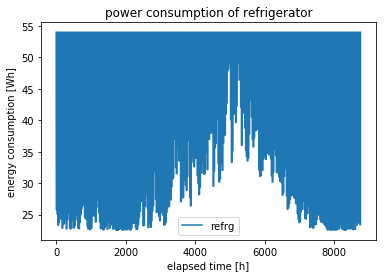

In [15]:
res = get_e_elec_refrigerator(2.0, False, 6.0, 60)

E_elc_y = res[0]
E_elc_d_t = res[1]

x = np.arange(8760)
y = E_elc_d_t

plt.plot(x, y, label='refrg')
plt.title('power consumption of refrigerator')
plt.xlabel('elapsed time [h]')
plt.ylabel('energy consumption [Wh]')
plt.legend()

plt.show()